In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm, tqdm_notebook
import cv2 as cv

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [31]:
# read dataset


train_data = pd.read_csv('../input/train.csv')
train_data.head()

training_path = '../input/train/train/'
test_path = '../input/test/test/'

images_train = []
labels_train = []

images = train_data['id'].values
for image_id in tqdm_notebook(images):
    
    image = np.array(cv.imread(training_path + image_id))
    label = train_data[train_data['id'] == image_id]['has_cactus'].values[0]
    
    images_train.append(image)
    labels_train.append(label)
    
    images_train.append(np.flip(image))
    labels_train.append(label)
    
    images_train.append(np.flipud(image))
    labels_train.append(label)
    
    images_train.append(np.fliplr(image))
    labels_train.append(label)
    
    
images_train = np.asarray(images_train)
images_train = images_train.astype('float32')
images_train /= 255.

labels_train = np.asarray(labels_train)



In [32]:
# read test set

test_images_names = []

for filename in os.listdir(test_path):
    test_images_names.append(filename)
    
test_images_names.sort()

images_test = []

for image_id in tqdm_notebook(test_images_names):
    images_test.append(np.array(cv.imread(test_path + image_id)))
    
images_test = np.asarray(images_test)
images_test = images_test.astype('float32')
images_test /= 255

In [33]:
# train/val split


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images_train, labels_train, test_size = 0.30, stratify = labels_train)


In [34]:
# augment data
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )


In [35]:
# build the model
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

model = Sequential()

# let's get 3 convolutional layers

model.add(Conv2D(filters=32, kernel_size=(3,3),
                 input_shape=(32,32,3), activation='relu',))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),
                 input_shape=(32,32,3), activation='relu',))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),
                 input_shape=(32,32,3), activation='relu',))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

# fully connected part of the network (158 neurons layer)

model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary, 0=cat , 1=dog
model.add(Dense(1))
model.add(Activation('sigmoid'))

# we compile the model selecting the loss function, the optimization function and our metric
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
__________

In [36]:
# define callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

weight_name = 'weights_aerial_cactus.h5'

callback = [EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          verbose=1, 
                          patience=10),
            ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001,
                              verbose=1),
            ModelCheckpoint(filepath = weight_name,
                            save_best_only=True,
                            save_weights_only=True,
                            verbose=1)]

In [38]:
# train the CNN
print('training on: ', len(x_train))
print('validating on: ', len(x_test))

model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=20),
    steps_per_epoch=len(x_train)/20, 
    validation_data=(x_test, y_test),
    epochs=100, 
    callbacks=callback
                   )

training on:  49000
validating on:  21000
Epoch 1/100
2450/2450 [==============================] - 67s 27ms/step - loss: 0.2193 - acc: 0.9155 - val_loss: 0.1400 - val_acc: 0.9439

Epoch 00001: val_loss improved from inf to 0.14003, saving model to weights_aerial_cactus.h5
Epoch 2/100
2450/2450 [==============================] - 68s 28ms/step - loss: 0.1336 - acc: 0.9495 - val_loss: 0.0866 - val_acc: 0.9651

Epoch 00002: val_loss improved from 0.14003 to 0.08659, saving model to weights_aerial_cactus.h5
Epoch 3/100
2450/2450 [==============================] - 69s 28ms/step - loss: 0.0964 - acc: 0.9633 - val_loss: 0.0599 - val_acc: 0.9777

Epoch 00003: val_loss improved from 0.08659 to 0.05990, saving model to weights_aerial_cactus.h5
Epoch 4/100
2450/2450 [==============================] - 69s 28ms/step - loss: 0.0772 - acc: 0.9719 - val_loss: 0.0823 - val_acc: 0.9664

Epoch 00004: val_loss did not improve from 0.05990
Epoch 5/100
2450/2450 [==============================] - 69s 28ms/st

In [39]:
# perform prediction
model.load_weights(weight_name)

predictions = model.predict(images_test, verbose = 1)

predictions



4000/4000 [==============================] - 1s 352us/step


array([[0.9999815 ],
       [1.        ],
       [0.00112909],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [42]:
# send results
test_df = pd.read_csv('../input/sample_submission.csv')
X_test = []
images_test = test_df['id'].values

for img_id in tqdm_notebook(images_test):
    X_test.append(cv.imread(test_path + img_id))
    
X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

y_test_pred = model.predict_proba(X_test)

test_df['has_cactus'] = y_test_pred
test_df.to_csv('aerial-cactus-submission.csv', index = False)

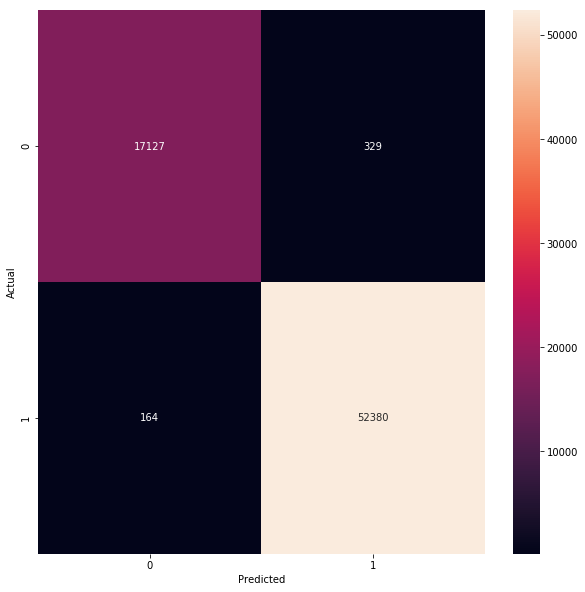

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     17456
           1       0.99      1.00      1.00     52544

   micro avg       0.99      0.99      0.99     70000
   macro avg       0.99      0.99      0.99     70000
weighted avg       0.99      0.99      0.99     70000



 AUC: 0.9997


In [49]:
# print report

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

x_tr = images_train
y_tr = labels_train

images_train = x_tr
labels_train = y_tr

y_pred_probability = model.predict_proba(x_tr)

y_pred = model.predict_classes(x_tr)
conf_matrix = confusion_matrix(y_tr, y_pred)
fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(conf_matrix, annot = True, fmt = 'd', xticklabels = ['0', '1'], yticklabels = ['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_tr, y_pred, target_names = ['0','1']))
print("\n\n AUC: {:<0.4f}".format(roc_auc_score(y_tr, y_pred_probability)))